# Prepping works

In [13]:
import os
import pandas as pd
import numpy as np
import pprint
import json
import cv2

import pickle # Load refs and annotations
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration 

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO
from PIL import Image, ImageDraw


In [5]:
import json

    
def getcaption(elem):
    li = []
    for e in elem["sentences"]:
        li.append(e['raw'])
    return li

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("../refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "captions": getcaption(elem),
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [6]:
with open("../refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("../refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

In [7]:
def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    pad_width = padded_width - original_width
    pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0)

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    return images, data

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="test")
print(dataset[0])
print("---------------------------------------------------")
#plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)

{'file_name': '../refcocog/images/COCO_train2014_000000380440.jpg', 'caption': 'the man in yellow coat', 'captions': ['the man in yellow coat', 'Skiier in red pants.'], 'ann_id': 491042, 'bbox': [374.31, 65.06, 136.04, 201.94]}
---------------------------------------------------


## Conteggio occorrenze caption per image

In [8]:
occ1 = 0
occ2 = 0
occ3 = 0
occG = 0

for e in dataset:
    if len(e['captions']) > 3:
        occG += 1
    elif len(e['captions']) > 2:
        occ3 += 1
    elif len(e['captions']) > 1:
        occ2 += 1
    else:
        occ1 += 1

print("occG = " + str(occG))
print("occ3 = " + str(occ3))
print("occ2 = " + str(occ2))
print("occ1 = " + str(occ1))

occG = 0
occ3 = 8
occ2 = 4563
occ1 = 452


In [9]:
# Models
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /Users/mattiacarolo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-4 Python-3.12.3 torch-2.3.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Using cache found in /Users/mattiacarolo/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-5-4 Python-3.12.3 torch-2.3.0 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 



 CAPTION:  the man in yellow coat
RESULTS:  [[     376.61      67.179      511.14      262.76     0.93059           0]
 [     230.68      43.151      371.29      307.86     0.93046           0]
 [     244.57      257.02       377.8      343.93     0.70347          30]
 [     346.71      212.95      518.61      268.03     0.44743          30]]


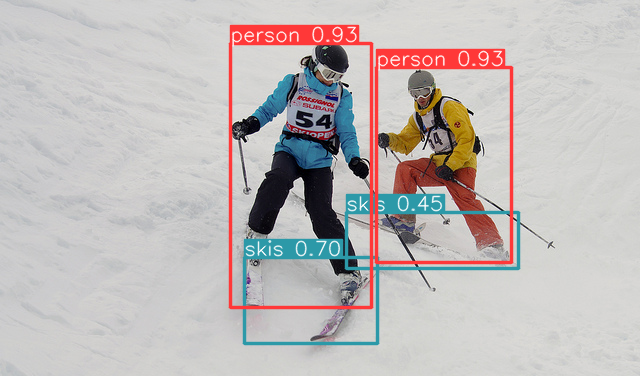

In [10]:
# Models
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
img = dataset[0]['file_name']
# Query
q = dataset[0]['caption']

# Inference
results = yolo_model(img)

# Results
print("\n CAPTION: ", q)
print("RESULTS: ", results.xyxy[0].cpu().numpy())
results.show()
#      xmin    ymin    xmax   ymax  confidence  class    name

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)
#text = clip.tokenize(q).to(device)

100%|███████████████████████████████████████| 244M/244M [01:40<00:00, 2.54MiB/s]
